# **Ensemble vs SubEnsemble Notebook**

##### This notebook will focus on clearly showing the differences between Ensemble and SubEnsemble.The main goal for this is that the training and evaluation must be fair for both ensemble and subensemble.They must have the same structure and be trained under the same time budget. The uncertainity distributions will be visualized by using histograms.. 


##### In order to get a better grasp at their differences, and make it as simple as possible to understand, first of all we need to understand , what an Ensemble and a SubEnsemble is?

## **Ensemble vs SubEnsemble**

### 1. The Full Ensemble ($\mathcal{E}$)
An **ensemble** is a set of $M$ predictive models, which are combined to reduce variance and improve robustness. Its behaviour reflects contributions from *all* members, typically including both high-performing **head** models and lower-performing but diverse **tail** models.
The ensemble set $\mathcal{E}$ is defined as:
$$
\mathcal{E}=\{h_1,\ldots,h_M\}
$$
The aggregated prediction $H(x)$ is computed through an aggregation function $\mathcal{A}$:
$$
H(x)=\mathcal{A}(h_1(x),\ldots,h_M(x))
$$

### 2. The Sub-Ensemble ($\mathcal{S}$)
A **sub-ensemble** is a set containing $K$ models, where $K$ is less than $M$. This subset is chosen according to a specific criterion.
The sub-ensemble $\mathcal{S}$ is defined as a proper subset:
$$
\mathcal{S}\subset\mathcal{E},\quad |\mathcal{S}|=K<M
$$
The predictor $H_{\mathcal{S}}(x)$ aggregates only the selected members:
$$
H_{\mathcal{S}}(x)=\mathcal{A}\big(h_i(x)\;|\;h_i\in\mathcal{S}\big)
$$

**Key difference:**  
- A full ensemble consists of multiple independent models, each with its own backbone and head. This maximizes model diversity and typically improves accuracy and uncertainty estimation, but it comes at a high computational cost.  

- A subensemble shares a common backbone across all members and uses multiple independent heads. This partial parameter sharing changes the bias–variance trade-off and the resulting uncertainty behavior. Because the expensive backbone computation is reused, subensembles are significantly cheaper to train and evaluate than full ensembles.



Now, lets dive into writing code.

**First step, import all the necessary libraries, load MNIST data, and set configuration parameters.** 

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from probly.transformation.ensemble import ensemble
from probly.transformation.subensemble import subensemble

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ],
)

BATCH_SIZE = 16

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)


print("MNIST Dataset Information:")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Test samples: {len(test_dataset):,}")
print("  Image shape: 28x28 (784 features when flattened)")
print(f"  Batch size: {BATCH_SIZE}")

MNIST Dataset Information:
  Training samples: 60,000
  Test samples: 10,000
  Image shape: 28x28 (784 features when flattened)
  Batch size: 16


**Since we are using MNIST, the data is fixed, respectively, we have train_dataset = 60,000 and test_dataset = 10,000 images. Each image has a shape of 1x28x28.**

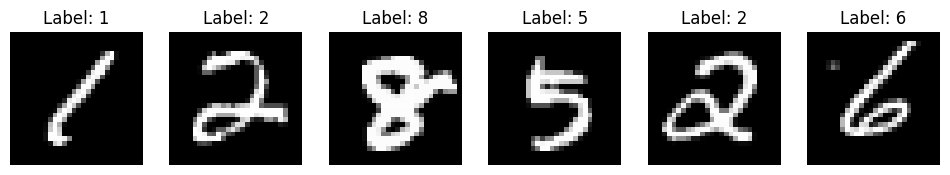

In [80]:
images, labels = next(iter(train_loader))


fig, axes = plt.subplots(1, 6, figsize=(12, 3))


for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")

plt.show()

**After generating the data we need for this notebook, we must generate a Base Model , which will act as a blueprint for both Ensemble and SubEnsemble.**

In [81]:
class BaseClassifier(nn.Module):
    """Base Classifier for MNIST classification using linear layers.

    This model serves as a blueprint for both Full Ensemble and SubEnsemble.

    Architecture:
    - Input: MNIST images of shape [batch_size, 1, 28, 28]
    - Backbone: Feature extractor (784 → H1 → H2)
      - Linear(784, H1) + ReLU
      - Linear(H1, H2) + ReLU
    - Head: Classification layer (H2 → 10 logits)
      - Linear(H2, 10)
    - Output: Logits of shape [batch_size, 10] (one for each MNIST class)

    The explicit backbone-head decomposition allows:
    - Full Ensemble: Each model has independent backbone and head
    - Sub-Ensemble: Shared backbone across all heads, independent heads only
    """

    def __init__(self, hidden_dim1: int = 512, hidden_dim2: int = 256) -> None:
        """Initialize BaseClassifier for MNIST classification."""
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(28 * 28, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
        )
        self.head = nn.Linear(hidden_dim2, 10)

    def forward_backbone(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through backbone only (feature extraction).

        This method is used for SubEnsemble architectures
        where multiple heads share the same backbone.

        Args:
            x: Input tensor of shape [batch_size, 1, 28, 28] or [batch_size, 28, 28]

        Returns:
            z: Latent representation of shape [batch_size, hidden_dim2]
        """
        x = x.view(x.size(0), -1)
        z = self.backbone(x)
        return z

    def forward_head(self, z: torch.Tensor) -> torch.Tensor:
        """Forward pass through head only (classification).

        Args:
            z: Latent representation of shape [batch_size, hidden_dim2]

        Returns:
            logits: Output tensor of shape [batch_size, 10]
        """
        logits = self.head(z)
        return logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through backbone and head.

        Since in a full ensemble each model is a complete classifier, This is the method
        needed for a Full Ensemble.

        Complete forward pass: input → backbone → head → logits.

        Args:
            x: Input tensor of shape [batch_size, 1, 28, 28] or [batch_size, 28, 28]

        Returns:
            logits: Output tensor of shape [batch_size, 10]
        """
        z = self.forward_backbone(x)
        logits = self.forward_head(z)
        return logits


def create_base_classifier(hidden_dim1: int = 512, hidden_dim2: int = 256) -> BaseClassifier:
    """Create a new BaseClassifier instance."""
    return BaseClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2)


base_model = create_base_classifier()

backbone_params = sum(p.numel() for p in base_model.backbone.parameters())
head_params = sum(p.numel() for p in base_model.head.parameters())
total_params = sum(p.numel() for p in base_model.parameters())

**Next step is to standardize two functions, respectively create_optimizer and create_scheduler and define shared training hyperparameters for fair Ensemble vs SubEnsemble comparison.**

In [82]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
MAX_EPOCHS = 20
T_MAX = MAX_EPOCHS


def create_optimizer(params: torch.nn.Parameter | list[torch.nn.Parameter] | torch.nn.Module) -> torch.optim.Optimizer:
    """Create an optimizer with shared hyperparameters for all ensemble and subensemble components."""
    return torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


def create_scheduler(optimizer: torch.optim.Optimizer) -> torch.optim.lr_scheduler.CosineAnnealingLR:
    """Create a learning-rate scheduler with shared hyperparameters for all models."""
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

**Device setup and timing configuration for fixed time budget training.**

The number of ensemble and subensemble members will be determined empirically by how many can be trained within the fixed time budget, which in our case is 60 seconds. This ensures a fair comparison under identical computational constraints.


In [83]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

TIME_BUDGET_SEC = 60
EPOCHS_PER_INCREMENT = 1

if torch.cuda.is_available():
    torch.cuda.synchronize()

print(f"Time budget: {TIME_BUDGET_SEC} seconds")
print(f"Epochs per increment: {EPOCHS_PER_INCREMENT}")
print(f"Batches per ensemble and subensemble step: {BATCH_SIZE}")

Using device: cpu
Time budget: 60 seconds
Epochs per increment: 1
Batches per ensemble and subensemble step: 16



**This section defines the loss function and basic evaluation tools used throughout the notebook.The model outputs logits (raw class scores), and we use CrossEntropyLoss to compare these logits with the true MNIST labels during training. This loss internally applies a softmax and provides a stable learning signal.**


In [84]:
criterion = nn.CrossEntropyLoss()


def evaluate_loss_and_accuracy(
    model: torch.nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    criterion: torch.nn.Module,
) -> tuple[float, float]:
    """Evaluate a model on a dataloader, returning average loss and accuracy."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader:
            inputs = batch_inputs.to(device)
            labels = batch_labels.to(device)

            logits = model(inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()

    model.train()
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy


def logits_to_probs(logits: torch.Tensor) -> torch.Tensor:
    """Convert logits to probabilities. Used for uncertainty/histograms later."""
    return torch.softmax(logits, dim=1)

**Train FULL ENSEMBLE AND SUB ENSEMBLE**

Empirically determine how many independent ensemble and subensemble members can be trained from scratch within the defined time budget.

In [85]:
full_ensemble_members = []
start_time = time.perf_counter()
budget_exceeded = False

while True:
    base_model = create_base_classifier()
    ensemble_module = ensemble(base_model, num_members=1, reset_params=True)
    model = ensemble_module[0].to(device)

    optimizer = create_optimizer(model.parameters())
    scheduler = create_scheduler(optimizer)

    model.train()
    member_trained = False

    for _epoch in range(EPOCHS_PER_INCREMENT):
        if budget_exceeded:
            break

        for batch_inputs, batch_labels in train_loader:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start_time
            if elapsed > TIME_BUDGET_SEC:
                budget_exceeded = True
                break

            inputs = batch_inputs.to(device)
            labels = batch_labels.to(device)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        if budget_exceeded:
            break

        if scheduler is not None:
            scheduler.step()

    if budget_exceeded:
        break

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = time.perf_counter() - start_time

    full_ensemble_members.append(model)
    member_trained = True
    print(f"Trained ensemble member {len(full_ensemble_members)}, elapsed: {elapsed:.2f}s")

if torch.cuda.is_available():
    torch.cuda.synchronize()
M_budget = len(full_ensemble_members)
total_time = time.perf_counter() - start_time
avg_time_per_member = total_time / M_budget if M_budget > 0 else 0

print("\nFull Ensemble Results:")
print(f"  Number of members trained (M_budget): {M_budget}")
print(f"  Total elapsed time: {total_time:.2f}s")
print(f"  Average time per member: {avg_time_per_member:.2f}s")

Trained ensemble member 1, elapsed: 9.89s
Trained ensemble member 2, elapsed: 18.91s
Trained ensemble member 3, elapsed: 27.65s
Trained ensemble member 4, elapsed: 36.40s
Trained ensemble member 5, elapsed: 45.11s
Trained ensemble member 6, elapsed: 54.13s

Full Ensemble Results:
  Number of members trained (M_budget): 6
  Total elapsed time: 60.03s
  Average time per member: 10.01s


In [ ]:
base_model = create_base_classifier().to(device)
base_backbone = base_model.backbone
base_head = base_model.head

subensemble_module = subensemble(
    base_backbone,
    num_heads=1,
    head=base_head,
    reset_params=True,
)
shared_backbone = subensemble_module[0].to(device)
heads = list(subensemble_module[1])
for head in heads:
    head.to(device)

optimizer_backbone = create_optimizer(shared_backbone.parameters())
optimizer_head0 = create_optimizer(heads[0].parameters())
scheduler_backbone = create_scheduler(optimizer_backbone)
scheduler_head0 = create_scheduler(optimizer_head0)

shared_backbone.train()
heads[0].train()
for _epoch in range(EPOCHS_PER_INCREMENT):
    for batch_inputs, batch_labels in train_loader:
        inputs = batch_inputs.to(device)
        labels = batch_labels.to(device)

        optimizer_backbone.zero_grad()
        optimizer_head0.zero_grad()

        z = shared_backbone(inputs.view(inputs.size(0), -1))
        logits = heads[0](z)
        loss = criterion(logits, labels)
        loss.backward()

        optimizer_backbone.step()
        optimizer_head0.step()

    if scheduler_backbone is not None:
        scheduler_backbone.step()
    if scheduler_head0 is not None:
        scheduler_head0.step()

for p in shared_backbone.parameters():
    p.requires_grad = False

shared_backbone.eval()


K_budget = 1
start_time = time.perf_counter()
budget_exceeded = False

head_optimizers = []
head_schedulers = []

while True:
    new_subensemble_module = subensemble(
        shared_backbone,
        num_heads=1,
        head=base_head,
        reset_params=True,
    )
    new_head = next(iter(new_subensemble_module[1])).to(device)
    heads.append(new_head)

    for old_head in heads[:-1]:
        for p in old_head.parameters():
            p.requires_grad = False

    for p in new_head.parameters():
        p.requires_grad = True

    head_optimizer = create_optimizer(new_head.parameters())
    head_scheduler = create_scheduler(head_optimizer)

    new_head.train()

    for _epoch in range(EPOCHS_PER_INCREMENT):
        if budget_exceeded:
            break

        for batch_inputs, batch_labels in train_loader:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start_time
            if elapsed > TIME_BUDGET_SEC:
                budget_exceeded = True
                break

            inputs = batch_inputs.to(device)
            labels = batch_labels.to(device)

            head_optimizer.zero_grad()

            with torch.no_grad():
                z = shared_backbone(inputs.view(inputs.size(0), -1))

            logits = new_head(z)
            loss = criterion(logits, labels)
            loss.backward()
            head_optimizer.step()

        if budget_exceeded:
            break

        if head_scheduler is not None:
            head_scheduler.step()

    if budget_exceeded:
        heads.pop()
        break

    K_budget += 1

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = time.perf_counter() - start_time
    print(f"Trained subensemble head {K_budget}, elapsed: {elapsed:.2f}s")

if torch.cuda.is_available():
    torch.cuda.synchronize()
total_time_sub = time.perf_counter() - start_time


print("\nSubEnsemble Results:")
print(f"  Number of heads trained (K_budget): {K_budget}")
print(f"  Total elapsed time: {total_time_sub:.2f}s")
print("\nComparison:")
print(f"  Full Ensemble members: {M_budget}")
print(f"  SubEnsemble heads: {K_budget}")

Trained subensemble head 2, elapsed: 3.98s
Trained subensemble head 3, elapsed: 8.01s
Trained subensemble head 4, elapsed: 12.01s
Trained subensemble head 5, elapsed: 16.02s
Trained subensemble head 6, elapsed: 20.13s
Trained subensemble head 7, elapsed: 24.15s
Trained subensemble head 8, elapsed: 28.12s
Trained subensemble head 9, elapsed: 32.12s
Trained subensemble head 10, elapsed: 36.42s
Trained subensemble head 11, elapsed: 40.57s
Trained subensemble head 12, elapsed: 44.54s
Trained subensemble head 13, elapsed: 48.52s
Trained subensemble head 14, elapsed: 52.47s
Trained subensemble head 15, elapsed: 56.52s

SubEnsemble Results:
  Number of heads trained (K_budget): 15
  Total elapsed time: 60.03s

Comparison:
  Full Ensemble members: 6
  SubEnsemble heads: 15


**Next step is to load Fashion-MNIST, which is a large, freely available dataset of fashion images that is commonly used for training and testing machine learning systems.**

In [87]:
fashion_train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

fashion_test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

fashion_train_loader = DataLoader(
    fashion_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

fashion_test_loader = DataLoader(
    fashion_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

print("FashionMNIST Dataset Information (evaluation only):")
print(f"  Training samples: {len(fashion_train_dataset):,}")
print(f"  Test samples: {len(fashion_test_dataset):,}")
print("  Image shape: 28x28 (same as MNIST)")
print(f"  Batch size: {BATCH_SIZE}")

FashionMNIST Dataset Information (evaluation only):
  Training samples: 60,000
  Test samples: 10,000
  Image shape: 28x28 (same as MNIST)
  Batch size: 16


Computing mutual information (epistemic uncertainty) for Full Ensemble...
Computing mutual information (epistemic uncertainty) for SubEnsemble...

Full Ensemble:
  MNIST - Mean: 0.0275, Median: 0.0025
  FashionMNIST - Mean: 0.1259, Median: 0.1116

SubEnsemble:
  MNIST - Mean: 0.0060, Median: 0.0007
  FashionMNIST - Mean: 0.0373, Median: 0.0282


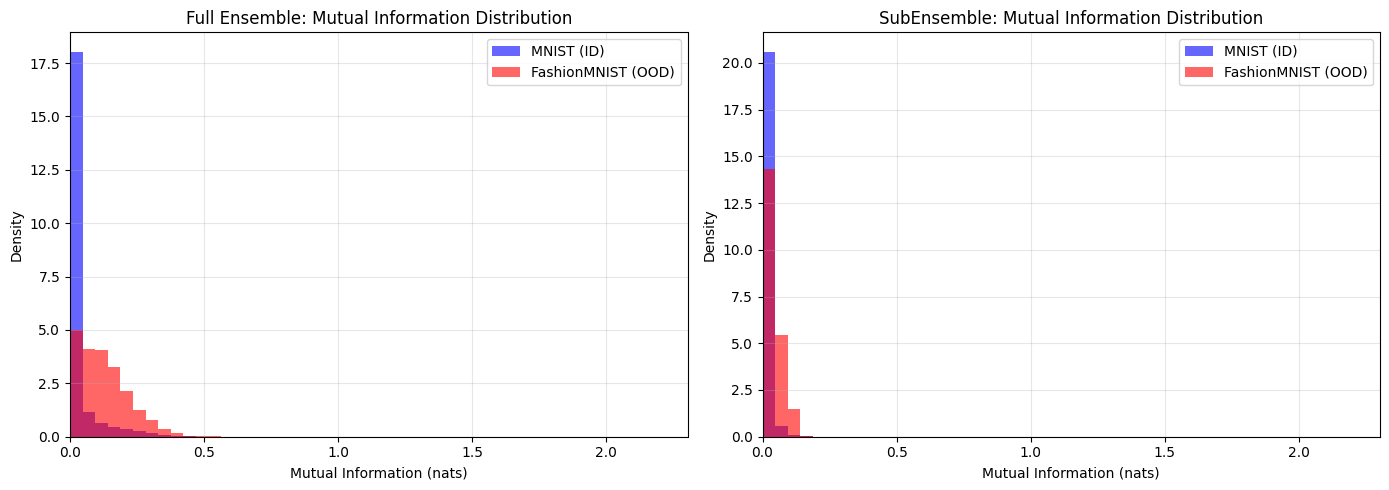

Histogram Interpretation:
  Left side (low MI): Low epistemic uncertainty (MNIST should dominate)
  Right side (high MI): High epistemic uncertainty (FashionMNIST should spread)


In [88]:
import math

from probly.quantification.classification import mutual_information

for model in full_ensemble_members:
    model.eval()
shared_backbone.eval()
for head in heads:
    head.eval()


print("Computing mutual information (epistemic uncertainty) for Full Ensemble...")
mnist_mi_ensemble = []
fashion_mi_ensemble = []

with torch.no_grad():
    for batch_inputs, _ in test_loader:
        inputs = batch_inputs.to(device)
        probs_list = []
        for model in full_ensemble_members:
            logits = model(inputs)
            probs = logits_to_probs(logits)
            probs_list.append(probs)
        probs_samples = torch.stack(probs_list, dim=0)
        probs_samples = probs_samples.permute(1, 0, 2)
        mi = mutual_information(probs_samples.detach().cpu().numpy(), base=math.e)
        mnist_mi_ensemble.extend(mi)

    for batch_inputs, _ in fashion_test_loader:
        inputs = batch_inputs.to(device)
        probs_list = []
        for model in full_ensemble_members:
            logits = model(inputs)
            probs = logits_to_probs(logits)
            probs_list.append(probs)
        probs_samples = torch.stack(probs_list, dim=0)
        probs_samples = probs_samples.permute(1, 0, 2)
        mi = mutual_information(probs_samples.detach().cpu().numpy(), base=math.e)
        fashion_mi_ensemble.extend(mi)

mnist_mi_ensemble = np.array(mnist_mi_ensemble)
fashion_mi_ensemble = np.array(fashion_mi_ensemble)


print("Computing mutual information (epistemic uncertainty) for SubEnsemble...")
mnist_mi_subensemble = []
fashion_mi_subensemble = []

with torch.no_grad():
    for batch_inputs, _ in test_loader:
        inputs = batch_inputs.to(device)
        z = shared_backbone(inputs.view(inputs.size(0), -1))
        probs_list = []
        for head in heads:
            logits = head(z)
            probs = logits_to_probs(logits)
            probs_list.append(probs)
        probs_samples = torch.stack(probs_list, dim=0)
        probs_samples = probs_samples.permute(1, 0, 2)
        mi = mutual_information(probs_samples.detach().cpu().numpy(), base=math.e)
        mnist_mi_subensemble.extend(mi)

    for batch_inputs, _ in fashion_test_loader:
        inputs = batch_inputs.to(device)
        z = shared_backbone(inputs.view(inputs.size(0), -1))
        probs_list = []
        for head in heads:
            logits = head(z)
            probs = logits_to_probs(logits)
            probs_list.append(probs)
        probs_samples = torch.stack(probs_list, dim=0)
        probs_samples = probs_samples.permute(1, 0, 2)
        mi = mutual_information(probs_samples.detach().cpu().numpy(), base=math.e)
        fashion_mi_subensemble.extend(mi)

mnist_mi_subensemble = np.array(mnist_mi_subensemble)
fashion_mi_subensemble = np.array(fashion_mi_subensemble)

print("\nFull Ensemble:")
mnist_mean = mnist_mi_ensemble.mean()
mnist_median = np.median(mnist_mi_ensemble)
print(f"  MNIST - Mean: {mnist_mean:.4f}, Median: {mnist_median:.4f}")
fashion_mean = fashion_mi_ensemble.mean()
fashion_median = np.median(fashion_mi_ensemble)
print(f"  FashionMNIST - Mean: {fashion_mean:.4f}, Median: {fashion_median:.4f}")
if fashion_mean <= mnist_mean:
    print("  WARNING: FashionMNIST MI <= MNIST MI!")
    print(
        "  Possible reasons: model overconfident on OOD, insufficient training, or distribution shift not captured.",
    )

print("\nSubEnsemble:")
sub_mnist_mean = mnist_mi_subensemble.mean()
sub_mnist_median = np.median(mnist_mi_subensemble)
print(f"  MNIST - Mean: {sub_mnist_mean:.4f}, Median: {sub_mnist_median:.4f}")
sub_fashion_mean = fashion_mi_subensemble.mean()
sub_fashion_median = np.median(fashion_mi_subensemble)
print(f"  FashionMNIST - Mean: {sub_fashion_mean:.4f}, Median: {sub_fashion_median:.4f}")
if sub_fashion_mean <= sub_mnist_mean:
    print("  WARNING: FashionMNIST MI <= MNIST MI!")
    print(
        "  Possible reasons: model overconfident on OOD, insufficient training, or distribution shift not captured.",
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
max_mi = math.log(10)
bins = np.linspace(0, max_mi, 50)
ax.hist(mnist_mi_ensemble, bins=bins, alpha=0.6, label="MNIST (ID)", density=True, color="blue")
ax.hist(fashion_mi_ensemble, bins=bins, alpha=0.6, label="FashionMNIST (OOD)", density=True, color="red")
ax.set_xlabel("Mutual Information (nats)")
ax.set_ylabel("Density")
ax.set_title("Full Ensemble: Mutual Information Distribution")
ax.set_xlim(0, max_mi)
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.hist(mnist_mi_subensemble, bins=bins, alpha=0.6, label="MNIST (ID)", density=True, color="blue")
ax.hist(fashion_mi_subensemble, bins=bins, alpha=0.6, label="FashionMNIST (OOD)", density=True, color="red")
ax.set_xlabel("Mutual Information (nats)")
ax.set_ylabel("Density")
ax.set_title("SubEnsemble: Mutual Information Distribution")
ax.set_xlim(0, max_mi)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Histogram Interpretation:")
print("  Left side (low MI): Low epistemic uncertainty (MNIST should dominate)")
print("  Right side (high MI): High epistemic uncertainty (FashionMNIST should spread)")

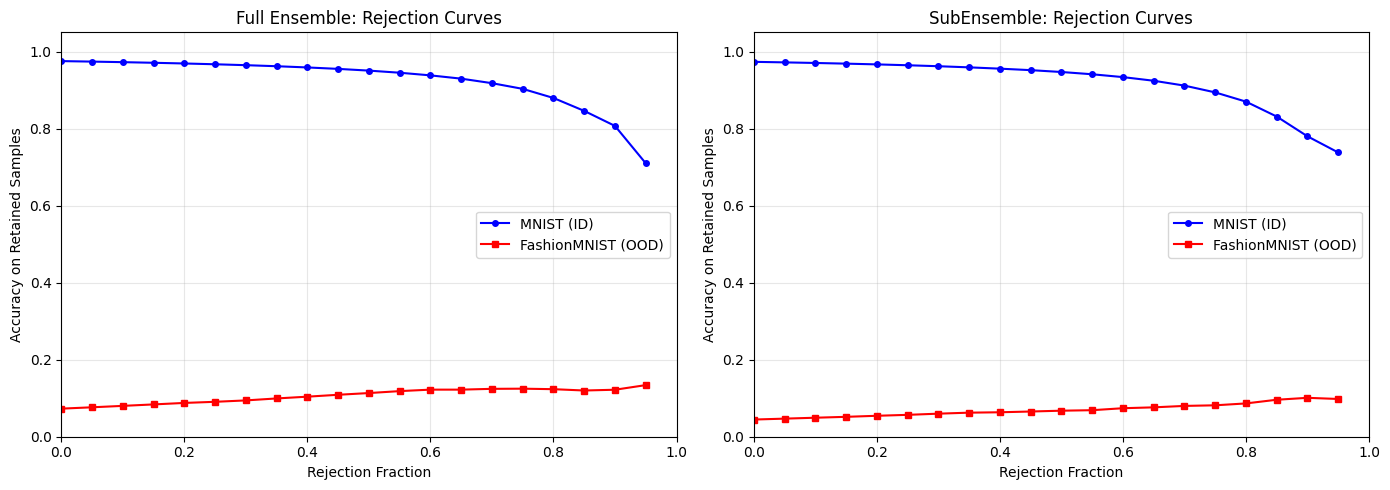


Rejection Curve Interpretation:
  Higher curves = better uncertainty calibration
  MNIST should show higher accuracy at all rejection fractions (better ID performance)
  FashionMNIST should show lower accuracy (OOD samples are harder to classify correctly)


In [ ]:
def compute_rejection_data(
    models_or_heads: list[torch.nn.Module],
    dataloader: DataLoader,
    is_subensemble: bool = False,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute predictions, labels, and MI for rejection curve analysis."""
    predictions = []
    labels_list = []
    mi_list = []

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader:
            inputs = batch_inputs.to(device)
            labels = batch_labels.to(device)

            probs_list = []
            if is_subensemble:
                z = shared_backbone(inputs.view(inputs.size(0), -1))
                for head in models_or_heads:
                    logits = head(z)
                    probs = logits_to_probs(logits)
                    probs_list.append(probs)
            else:
                for model in models_or_heads:
                    logits = model(inputs)
                    probs = logits_to_probs(logits)
                    probs_list.append(probs)

            probs_samples = torch.stack(probs_list, dim=0)
            probs_samples = probs_samples.permute(1, 0, 2)

            pred_mean_probs = probs_samples.mean(dim=1)
            pred_labels = torch.argmax(pred_mean_probs, dim=1)

            mi = mutual_information(probs_samples.detach().cpu().numpy(), base=math.e)

            predictions.extend(pred_labels.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            mi_list.extend(mi)

    return np.array(predictions), np.array(labels_list), np.array(mi_list)


mnist_preds_ensemble, mnist_labels_ensemble, mnist_mi_ensemble_rej = compute_rejection_data(
    full_ensemble_members,
    test_loader,
    is_subensemble=False,
)
fashion_preds_ensemble, fashion_labels_ensemble, fashion_mi_ensemble_rej = compute_rejection_data(
    full_ensemble_members,
    fashion_test_loader,
    is_subensemble=False,
)

mnist_preds_subensemble, mnist_labels_subensemble, mnist_mi_subensemble_rej = compute_rejection_data(
    heads,
    test_loader,
    is_subensemble=True,
)
fashion_preds_subensemble, fashion_labels_subensemble, fashion_mi_subensemble_rej = compute_rejection_data(
    heads,
    fashion_test_loader,
    is_subensemble=True,
)


def compute_rejection_curve(
    predictions: np.ndarray,
    labels: np.ndarray,
    uncertainties: np.ndarray,
    rejection_fractions: np.ndarray,
) -> np.ndarray:
    """Compute accuracy at different rejection fractions."""
    accuracies = []
    sorted_indices = np.argsort(uncertainties)
    sorted_predictions = predictions[sorted_indices]
    sorted_labels = labels[sorted_indices]

    n_samples = len(predictions)

    for t in rejection_fractions:
        n_remove = int(t * n_samples)
        if n_remove >= n_samples:
            accuracies.append(0.0)
            continue

        retained_predictions = sorted_predictions[n_remove:]
        retained_labels = sorted_labels[n_remove:]

        accuracy = np.mean(retained_predictions == retained_labels)
        accuracies.append(accuracy)

    return np.array(accuracies)


rejection_fractions = np.linspace(0, 0.95, 20)

mnist_curve_ensemble = compute_rejection_curve(
    mnist_preds_ensemble,
    mnist_labels_ensemble,
    mnist_mi_ensemble_rej,
    rejection_fractions,
)
fashion_curve_ensemble = compute_rejection_curve(
    fashion_preds_ensemble,
    fashion_labels_ensemble,
    fashion_mi_ensemble_rej,
    rejection_fractions,
)

mnist_curve_subensemble = compute_rejection_curve(
    mnist_preds_subensemble,
    mnist_labels_subensemble,
    mnist_mi_subensemble_rej,
    rejection_fractions,
)
fashion_curve_subensemble = compute_rejection_curve(
    fashion_preds_subensemble,
    fashion_labels_subensemble,
    fashion_mi_subensemble_rej,
    rejection_fractions,
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(rejection_fractions, mnist_curve_ensemble, label="MNIST (ID)", color="blue", marker="o", markersize=4)
ax.plot(rejection_fractions, fashion_curve_ensemble, label="FashionMNIST (OOD)", color="red", marker="s", markersize=4)
ax.set_xlabel("Rejection Fraction")
ax.set_ylabel("Accuracy on Retained Samples")
ax.set_title("Full Ensemble: Rejection Curves")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(rejection_fractions, mnist_curve_subensemble, label="MNIST (ID)", color="blue", marker="o", markersize=4)
ax.plot(
    rejection_fractions,
    fashion_curve_subensemble,
    label="FashionMNIST (OOD)",
    color="red",
    marker="s",
    markersize=4,
)
ax.set_xlabel("Rejection Fraction")
ax.set_ylabel("Accuracy on Retained Samples")
ax.set_title("SubEnsemble: Rejection Curves")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRejection Curve Interpretation:")
print("  Higher curves = better uncertainty calibration")
print("  MNIST should show higher accuracy at all rejection fractions (better ID performance)")
print("  FashionMNIST should show lower accuracy (OOD samples are harder to classify correctly)")